In [1]:
import logging
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA 
from IPython.display import display, Latex

from randnn import downsample, downsample_split, avg_over
from randnn.utils import np_cache, eigsort
from randnn.plotting import *
from randnn.systems import DoubleWell
from randnn.transfer_operator import *

rc('text', usetex=True)
logging.basicConfig(level=logging.INFO)

# Applying the transfer operator approach

### 1. Coarse-graining in space:

#### Clustering

We run an explicit coarse-graining step by clustering the embedding space.

### 2. Coarse-graining in time: 

#### Downsampling
We are interested in the long-term behavior of the system (and have finitely powerful computers), so we downsample the trajectory, discarding many intermediate timesteps.

#### Delay embedding
To achieve a near-memory-less (Markovian) definition of state, we stack delayed copies of measurements within a short time window.

# Parameters

In [2]:
# ------------------------
# DOUBLE WELL PARAMETERS
# ------------------------

# Main parameters:
BETA = 2.

# The following parameters influence temporal resolution and trajectory duration
TIMESTEP = 0.1
N_STEPS = 100000
N_BURNIN_STEPS = 500


# ------------------------
# COARSE-GRAINING IN SPACE
# ------------------------

# Explicitly coarse-graining the phase space by clustering (should be << # of downsampled timesteps)
N_CLUSTERS = 100 

# -----------------------
# COARSE-GRAINING IN TIME 
# ------------------------

# Increasing downsampling and transition time have about the same effect: 
# it increases the length of the time-scales we are interested in
DOWNSAMPLE_RATE = 10
TRANSITION_TIMESCALE = 20 # This is the number of timesteps to take before counting a transition from one cell to the next

# -----------------------
# STATE-SPACE RECONSTRUCTION
# ------------------------

# N delays tells me how many times to stack states into my definition of state.
N_DELAYS = 0

# Embedding dimension is the downprojected space after doing a delay embedding
EMBEDDING_DIM = 3

# -----------------------
# PLOTTING PARAMETERS
# ------------------------

EIGENVALUE_RANGE = [1, 10]

Generating samples: 100%|██████████| 100000/100000 [00:02<00:00, 44203.92it/s]
INFO:root:Saving to ./saves/trajectories/trajectory-f710dbdfd39c5d3433acc46f161d51e2.npy
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1267: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


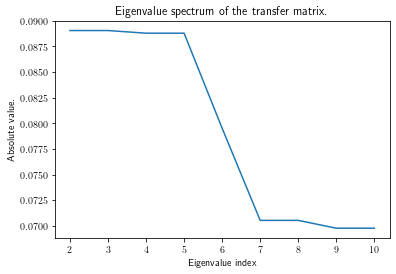

In [3]:
double_well = DoubleWell(beta=BETA, timestep=TIMESTEP)
dominant_eigval= double_well.dominant_eigval
dominant_timescale = double_well.dominant_timescale * DOWNSAMPLE_RATE

@downsample(DOWNSAMPLE_RATE)
def get_trajectory(beta=BETA, n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS, t_ons=100):
    double_well = DoubleWell(beta=beta, timestep=TIMESTEP, is_overdamped=True)
    return double_well.run(n_steps=n_steps, n_burn_in=n_burn_in)

trajectory = get_trajectory()

transfer_operator = TransferOperator(labeling_method="kmeans")

def get_trans_matrix(time_series=None, n_clusters=100, n_future_timesteps=TRANSITION_TIMESCALE):
    return transfer_operator.get_trans_matrix(time_series=time_series, n_clusters=n_clusters, n_future_timesteps=n_future_timesteps)

trans_matrix = get_trans_matrix(time_series=trajectory)
spectrum, _ = eigsort(trans_matrix.T, 100, which='LR')
plot_eig_spectrum(spectrum, EIGENVALUE_RANGE, "Eigenvalue spectrum of the transfer matrix.")


## Implied timescales

The eigenvalues of the transfer matrix correspond to unique (implied) timescales. 
They are related by $t_\text{imp} = -\tau / \log|\lambda|$, where: 
- $t_\text{imp}$ is the implied timescale,
- $\tau$ is the discretization timestep, and
- $\lambda$ is the eigenvalue for which we want the corresponding timescale.
   
   
For now, we're interested in the dominant timescale, i.e. the timescale corresponding to the second largest eigenvalue (as the first corresponds to the stationary distribution with an infinite timescale).

To verify everything's working properly, we can compare our result to the actual value, computed analytically (though not exactly). 

#### Analytic treatment

This result we can take from Voigtlaender and Risken (1984). They treat a particle of mass $m$ moving in a potential of the form $f(x) = ax^2+bx^4$ (so $a<0$, $b>0$). This is coupled to a heat bath of temperature $T$, and is subject to a friction of constant $\gamma$. The energy scale is $\theta=kT/m$.

In the high-barrier limit (the one we're interested in), we derive the following eigenvalue,
$$\lambda(a,b,\gamma, \theta)=\sqrt{-a}\cdot\tilde\lambda\left(\frac{\gamma}{\sqrt{-a}}, \frac{\theta b}{a^2}\right),$$
in terms of a reparametrized eigenvalue:
$$\tilde\lambda(\tilde \gamma, \tilde \theta) = \frac{\sqrt{2}}{\pi}\left(\sqrt{\frac{\tilde\gamma^2}{4}+1}-\frac{\gamma}{2}\right)\exp\left(\frac{-1}{4\tilde\theta}\right).$$

In our case, we have chosen $f(x) = (x^2-1)^2$, i.e. $a=-4$, $b=4$ (the constant doesn't have any physical bearing since it amounts to reshifting the ground energy). Our particle has mass $m=1$ (i.e. we have already reabsorbed this into the temperature. I believe $\gamma=1$, i.e. we focus only on changing the temperature (equivalently $\theta$). 

Then, the expression above reduces:
$$
\begin{align}
\lambda(-4, 4, 1, \theta)
&=\sqrt{4}\cdot\tilde\lambda\left(\frac{1}{2}, \frac{\theta}{4}\right)\\
&=\frac{\sqrt{17}-1}{\pi\sqrt{2}} \exp(-1/\theta).
\end{align}
$$



In [5]:
display(Latex("For $\\beta = {}$, $\lambda={}$, and $r=\lambda/2={}$".format(BETA, dominant_eigval, dominant_eigval/2)))
display(Latex("With a discretization timestep of $\\tau={}$, and a downsampling rate of $R={}$, we get $\\tau={}$"
              .format(TIMESTEP, DOWNSAMPLE_RATE, dominant_timescale)))

display(Latex("Time until half: $\ln 0.5/ \ln \lambda = {}$".format(1./(dominant_eigval))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
N_CLUSTERS_LIST = [10, 100, 500]
TRANSITION_TIMES = range(1, 20, 4)

plot_t_imp_scaling(trajectory, 
                   1, 
                   n_clusters_list=N_CLUSTERS_LIST, 
                   transition_times=TRANSITION_TIMES,
                   timestep=TIMESTEP/DOWNSAMPLE_RATE)

In [ ]:
def plot_t_imps(time_series, eigval_idxs=range(1,3), n_clusters=N_CLUSTERS, transition_timescales=range(1, 10, 2), timestep=1):
    plt.title("Scaling of $t$ with $\\tau$ and $n_p$")
    t_imps = np.zeros((len(transition_timescales), len(eigval_idxs)))

    for i, tau in tqdm(enumerate(transition_timescales), desc="computing t_imp"):
        t_imps[i, :] = transfer_operator.get_t_imp(time_series, eigval_idxs, n_clusters, tau, timestep)
    
    for i in eigval_idxs:
        plt.plot(transition_timescales, t_imps[:, i])

    plt.show()
    
plot_t_imps(trajectory)